The goal of this notebook is to investigate the variance of OTUs in the different sites.

This is in response to Rafa's suggestions after I went to group meeting and asked for advice on how to make statements about the similarities between communities.

My hope is that we'll see:

- OTUs are on average less variable across throat samples than stomach or lungs
- in stomach, lungs, and (to a lesser extent) throat, we'll see some OTUs that are similarly variable across people in both sites (these are the more "core" OTUs) and others that have quite different variances
- There might also be some sort of presence/absence signal (here we'll be able to see if there are OTUs that are very variable in one site but rarely present in another)



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util

/Users/claire/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fraw = '../../data/clean/rosen.otu_table.counts.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
raw = pd.read_csv(fraw, sep='\t', index_col=0)

In [4]:
sites = util.get_sites()
sites

['bal', 'gastric_fluid', 'throat_swab']

In [5]:
# Convert dataframe to tidy format
df.index.name = 'sample'
dflong = pd.melt(df.reset_index(), id_vars=['sample'], var_name='otu',
                 value_name='abun')
dflong = dflong.merge(
            meta[['site', 'subject_id']],
            left_on='sample', right_index=True)

In [6]:
# Add one pseudo-count and take the log of raw counts df
raw = np.log10(raw + 1)
# Also convert to tidy
raw.index.name = 'sample'
rawlong = pd.melt(raw.reset_index(), id_vars=['sample'], var_name='otu',
                 value_name='abun')
rawlong = rawlong.merge(
            meta[['site', 'subject_id']],
            left_on='sample', right_index=True)

In [7]:
dflong.head()

,sample,otu,abun,site,subject_id
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025542,gastric_fluid,01-112-7
628,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7
1256,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7
1884,01-112-7GI,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000000,gastric_fluid,01-112-7
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7


In [8]:
rawlong.head()

,sample,otu,abun,site,subject_id
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,3.839918,gastric_fluid,01-112-7
628,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7
1256,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7
1884,01-112-7GI,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000000,gastric_fluid,01-112-7
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7


In [9]:
meta.groupby(['subject_id', 'site']).size().max()

3

(array([ 179.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

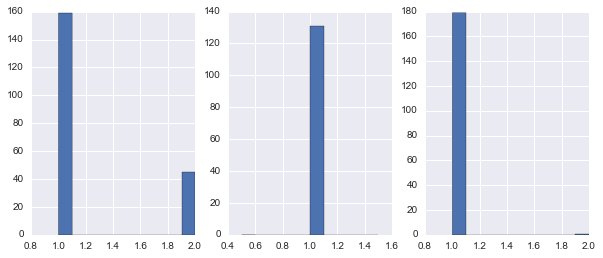

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].hist(meta.query('site == "throat_swab"').groupby('subject_id').size())
ax[1].hist(meta.query('site == "bal"').groupby('subject_id').size())
ax[2].hist(meta.query('site == "gastric_fluid"').groupby('subject_id').size())

Need to remove the duplicate throat swabs from the same patient, otherwise this will artifically lower the variance of the OTUs in the throat...

In [11]:
# Get all subjects with throat samples
throatsubjs = meta\
    .query('site == "throat_swab"')\
    .groupby('subject_id')\
    .size()\
    .to_frame(name='n_samples')\
    .reset_index()

# Get subjects with more than 1 throat sample
dupsubjs = throatsubjs\
    .query('n_samples > 1')\
    ['subject_id']\
    .tolist()

# Get sample IDs corresponding to these duplicate samples
dupsamples = meta\
    .query('site == "throat_swab"')\
    .query('subject_id == @dupsubjs')\
    .index\
    .tolist()

# All of these samples are either in the TI/TF or F1/F2 studies
# Keep only the TI and F1 ones
dropsamples = [i for i in dupsamples if 'I' not in i and 'F1' not in i]

print('Duplicate subjects: {}, samples: {}, duplicated samples: {}'
      .format(len(dupsubjs), len(dupsamples), len(dropsamples)))


Duplicate subjects: 45, samples: 90, duplicated samples: 46


In [12]:
# Grab the sites of interest
dflong = dflong.query('site == @sites')
rawlong = rawlong.query('site == @sites')

# Get rid of the duplicate throat samples
dflong = dflong.query('sample != @dropsamples')
rawlong = rawlong.query('sample != @dropsamples')

## Looking at relative abundances

In [11]:
# Use groupby's describe function to get OTU-wise stats
otustats = dflong.groupby(['site', 'otu']).describe().reset_index()
otustats.head()

site                                                otu   abun            \
                                                           count      mean   
0  bal           k__;p__;c__;o__;f__;g__;s__;d__denovo120  131.0  0.006750   
1  bal  k__Archaea;p__Euryarchaeota;c__Methanobacteria...  131.0  0.000000   
2  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053  131.0  0.000135   
3  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182  131.0  0.000012   
4  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187  131.0  0.000000   

                                           
        std  min  25%  50%  75%       max  
0  0.054639  0.0  0.0  0.0  0.0  0.490741  
1  0.000000  0.0  0.0  0.0  0.0  0.000000  
2  0.001508  0.0  0.0  0.0  0.0  0.017260  
3  0.000084  0.0  0.0  0.0  0.0  0.000887  
4  0.000000  0.0  0.0  0.0  0.0  0.000000

In [53]:
# I really need to learn how to use Multi-Indices...
cols = ['site', 'otu', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
otustats.columns = cols

In [54]:
otustats.head()

,site,otu,count,mean,std,min,25%,50%,75%,max
0,bal,k__;p__;c__;o__;f__;g__;s__;d__denovo120,131.0,0.006750,0.054639,0.0,0.0,0.0,0.0,0.490741
1,bal,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,131.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,131.0,0.000135,0.001508,0.0,0.0,0.0,0.0,0.017260
3,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,131.0,0.000012,0.000084,0.0,0.0,0.0,0.0,0.000887
4,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,131.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [55]:
otus = otustats['otu'].unique().tolist()

In [56]:
# Get dataframe with the standard devs
sitestd = otustats.pivot(index='otu', columns='site', values='std')
sitestd.columns = [c + '-std' for c in sitestd.columns]
# Take log and add small value to fill in for zeros
sitestd = np.log10(sitestd + 1e-7)
sitestd.head()

,bal-std,gastric_fluid-std,throat_swab-std
otu,,,
k__;p__;c__;o__;f__;g__;s__;d__denovo120,-1.262493,-3.050437,-4.324143
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__;d__denovo285,-7.000000,-6.665512,-5.578904
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,-2.821600,-4.257575,-5.688781
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,-4.075773,-4.423765,-4.202848
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,-7.000000,-7.000000,-5.476347


In [57]:
# Get another dataframe with the mean abundance
sitemean = otustats.pivot(index='otu', columns='site', values='mean')
sitemean.columns = [c + '-mean' for c in sitemean.columns]
# Take log and add small value to fill in for zeros
sitemean = np.log10(sitemean + 1e-8)
sitemean.head()

,bal-mean,gastric_fluid-mean,throat_swab-mean
otu,,,
k__;p__;c__;o__;f__;g__;s__;d__denovo120,-2.170724,-4.021278,-5.427156
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__;d__denovo285,-8.000000,-7.729939,-6.725712
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,-3.870248,-5.084987,-6.746419
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,-4.921254,-5.043842,-5.200296
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,-8.000000,-8.000000,-6.624606


In [58]:
# Merge dataframes on OTU
sitestats = pd.merge(sitestd, sitemean, left_index=True, right_index=True)

In [17]:
def plotxy(x, y, df, ax, yx=False):
    c = sns.color_palette('Set1', 2)[1]
    # x and y are column names in df, ax is axis handle
    ax.scatter(df[x], df[y], c=c, alpha=0.6)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    if yx:
        minx = min(df[x].min(), df[y].min())
        maxx = max(df[x].max(), df[y].max())
        ax.plot([minx, maxx], [minx, maxx], '--', c='0.15', linewidth=2.5)


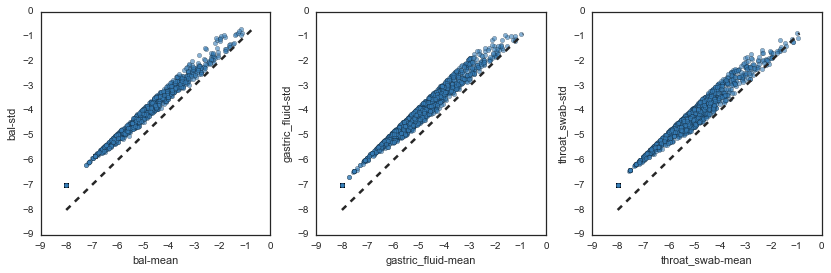

In [60]:
# Plot mean vs. std in each site
sns.set_style('white')
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('bal-mean', 'bal-std', sitestats, ax[0], yx=True)
plotxy('gastric_fluid-mean', 'gastric_fluid-std', sitestats, ax[1], yx=True)
plotxy('throat_swab-mean', 'throat_swab-std', sitestats, ax[2], yx=True)

Damnit, this is a problem, right?

Rafa mentioned something about how looking for presence/absence may circumvent the issues presented by this...

Right now, my variance plot btw sites is just the same thing as the mean across sites -- but I am really only interested in variance so this isn't good enough. Can't remember how to fix this... maybe taking log before calculating std?

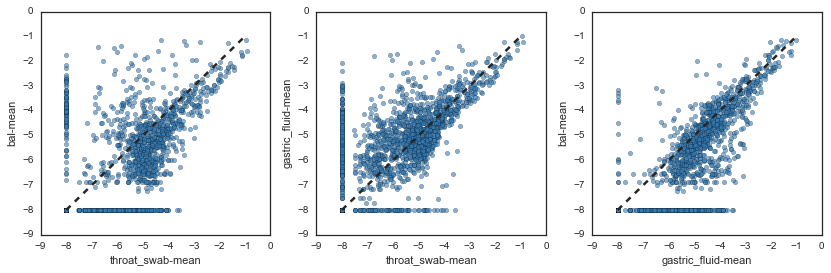

In [61]:
# Plot mean across sites
sns.set_style('white')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    
plotxy('throat_swab-mean', 'bal-mean', sitestats, ax[0], yx=True)
plotxy('throat_swab-mean', 'gastric_fluid-mean', sitestats, ax[1], yx=True)
plotxy('gastric_fluid-mean', 'bal-mean', sitestats, ax[2], yx=True)

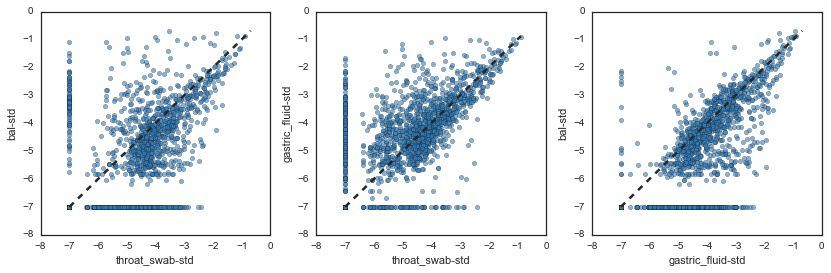

In [62]:
# Plot std across sites
sns.set_style('white')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    
plotxy('throat_swab-std', 'bal-std', sitestats, ax[0], yx=True)
plotxy('throat_swab-std', 'gastric_fluid-std', sitestats, ax[1], yx=True)
plotxy('gastric_fluid-std', 'bal-std', sitestats, ax[2], yx=True)

Okay, let's think about how to interpret this plot...

OTUs on the horizontal line are ones that are present in some subset of the x-axis site but are not in the y-axis site. From axis 1, looks like there's lots more OTUs present in the throat that aren't present in BAL than the other way around. From axis 3, there are a lot of bugs present in the gastric fluid that aren't in BAL ever.

**Axis 1**: Most OTUs are slightly more variable across people's throats than their lungs, but there are more extreme variations across people's lungs.

**Axis 2**: Many OTUs are more variable across people's stomachs than their throats. 

**Axis 3**: Most OTUs are more variable across people's stomachs than their lungs. There are also a lot of OTUs that are present in people's stomachs that aren't present in their lungs.  

Also I should look at proportion of OTUs never found in one site but which are present elsewhere. Maybe more interestingly: can look at total number of OTUs present in all three sites vs. each site como.

Wait, before we go crazy interpreting this, I need to somehow encode mean into this...

### Try again, but this time looking at stats of the log abuns

In [63]:
dflong.replace(0, np.nan).min()

sample                                      01-112-7GI
otu           k__;p__;c__;o__;f__;g__;s__;d__denovo120
abun                                       1.56085e-06
site                                               bal
subject_id                                    01-112-7
dtype: object

In [64]:
dflong['log_abun'] = np.log10(dflong['abun'] + 1e-7)

In [65]:
# Use groupby's describe function to get OTU-wise stats
otustats = dflong.groupby(['site', 'otu']).describe().reset_index()
otustats.head()

site                                                otu   abun            \
                                                           count      mean   
0  bal           k__;p__;c__;o__;f__;g__;s__;d__denovo120  131.0  0.006750   
1  bal  k__Archaea;p__Euryarchaeota;c__Methanobacteria...  131.0  0.000000   
2  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053  131.0  0.000135   
3  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182  131.0  0.000012   
4  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187  131.0  0.000000   

                                          log_abun                           \
        std  min  25%  50%  75%       max    count      mean       std  min   
0  0.054639  0.0  0.0  0.0  0.0  0.490741    131.0 -6.842596  0.930770 -7.0   
1  0.000000  0.0  0.0  0.0  0.0  0.000000    131.0 -7.000000  0.000000 -7.0   
2  0.001508  0.0  0.0  0.0  0.0  0.017260    131.0 -6.871544  0.674782 -7.0   
3  0.000084  0.0  0.0  0.0  0.0  0.000887    131.0 -6.839203  0.692508 -7.0   
4  0.000000  0.0  0.0  0.0  0.0  0.000000    131.0 -7.000000  0.000000 -7.0   

                            
   25%  50%  75%       max  
0 -7.0 -7.0 -7.0 -0.309148  
1 -7.0 -7.0 -7.0 -7.000000  
2 -7.0 -7.0 -7.0 -1.762957  
3 -7.0 -7.0 -7.0 -3.052123  
4 -7.0 -7.0 -7.0 -7.000000

In [66]:
# I really need to learn how to use Multi-Indices...
cols = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
cols = ['site', 'otu'] + ['abun-' + c for c in cols] + ['log_abun-' + c for c in cols]
otustats.columns = cols
otustats.head()

,site,otu,abun-count,abun-mean,abun-std,abun-min,abun-25%,abun-50%,abun-75%,abun-max,log_abun-count,log_abun-mean,log_abun-std,log_abun-min,log_abun-25%,log_abun-50%,log_abun-75%,log_abun-max
0,bal,k__;p__;c__;o__;f__;g__;s__;d__denovo120,131.0,0.006750,0.054639,0.0,0.0,0.0,0.0,0.490741,131.0,-6.842596,0.930770,-7.0,-7.0,-7.0,-7.0,-0.309148
1,bal,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,131.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,131.0,-7.000000,0.000000,-7.0,-7.0,-7.0,-7.0,-7.000000
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,131.0,0.000135,0.001508,0.0,0.0,0.0,0.0,0.017260,131.0,-6.871544,0.674782,-7.0,-7.0,-7.0,-7.0,-1.762957
3,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,131.0,0.000012,0.000084,0.0,0.0,0.0,0.0,0.000887,131.0,-6.839203,0.692508,-7.0,-7.0,-7.0,-7.0,-3.052123
4,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,131.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,131.0,-7.000000,0.000000,-7.0,-7.0,-7.0,-7.0,-7.000000


In [67]:
## Convert to wide dataframe with mean and std in each site in columns, otus in rows

# Get dataframe with the standard devs
sitestd = otustats.pivot(index='otu', columns='site', values='log_abun-std')
sitestd.columns = [c + '-std' for c in sitestd.columns]

# Get another dataframe with the mean abundance
sitemean = otustats.pivot(index='otu', columns='site', values='log_abun-mean')
sitemean.columns = [c + '-mean' for c in sitemean.columns]

# Merge dataframes on OTU
sitestatslogged = pd.merge(sitestd, sitemean, left_index=True, right_index=True)

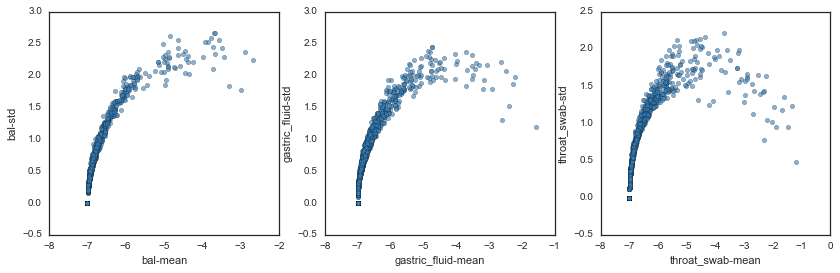

In [68]:
# Plot mean vs. std of logged abundances in each site
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('bal-mean', 'bal-std', sitestatslogged, ax[0])
plotxy('gastric_fluid-mean', 'gastric_fluid-std', sitestatslogged, ax[1])
plotxy('throat_swab-mean', 'throat_swab-std', sitestatslogged, ax[2])

### What about coefficient of variation?

In [69]:
otustats['log_abun-cv'] = otustats['log_abun-std']/otustats['log_abun-mean']

# Get dataframe with the standard devs
cvlog = otustats.pivot(index='otu', columns='site', values='log_abun-cv')
cvlog.head()

site,bal,gastric_fluid,throat_swab
otu,,,
k__;p__;c__;o__;f__;g__;s__;d__denovo120,-0.136026,-0.100292,-0.064495
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__;d__denovo285,-0.000000,-0.012971,-0.025707
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,-0.098200,-0.092750,-0.030872
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,-0.101256,-0.124567,-0.091728
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,-0.000000,-0.000000,-0.026772


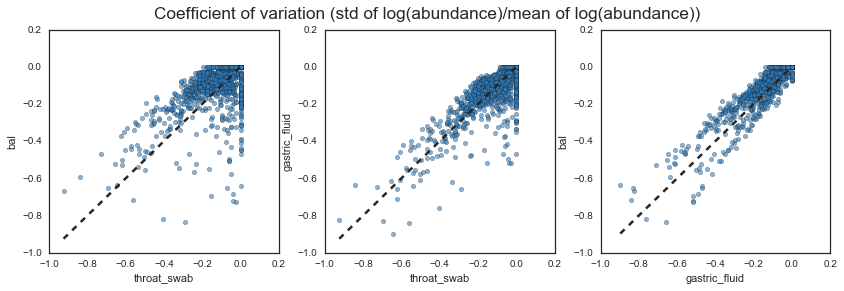

In [70]:
# Plot cv between sites
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('throat_swab', 'bal', cvlog, ax[0], yx=True)
plotxy('throat_swab', 'gastric_fluid', cvlog, ax[1], yx=True)
plotxy('gastric_fluid', 'bal', cvlog, ax[2], yx=True)
plt.suptitle('Coefficient of variation (std of log(abundance)/mean of log(abundance))', fontsize='xx-large')

CV = std/mean. So horizontal and verticals are when the OTU is zero in all samples.

Not sure if this is legit - will ask Rafa.

In [72]:
# What about CV of non-logged abundance?
# First, are any mean abundances zero?
otustats['abun-mean'].sort_values().head()

4733    0.0
936     0.0
935     0.0
933     0.0
932     0.0
Name: abun-mean, dtype: float64

In [73]:
# What about CV of non-logged abundance?
otustats['abun-cv'] = otustats['abun-std']/otustats['abun-mean']

# Get dataframe with the standard devs
cv = otustats.pivot(index='otu', columns='site', values='abun-cv')

otustats[['site', 'otu', 'abun-mean', 'abun-std', 'abun-cv', 'log_abun-mean', 'log_abun-std', 'log_abun-cv']]\
    .sort_values(by=['site', 'abun-cv'], ascending=[True, True]).head(15)

,site,otu,abun-mean,abun-std,abun-cv,log_abun-mean,log_abun-std,log_abun-cv
495,bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.006041,0.008751,1.448687,-3.291382,1.829903,-0.555968
517,bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.035687,0.051899,1.454283,-3.661189,2.664443,-0.727753
514,bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.017789,0.026357,1.481654,-3.855851,2.521259,-0.653879
1522,bal,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.025675,0.038112,1.484421,-3.484191,2.424254,-0.695787
512,bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.033760,0.050247,1.488346,-3.699504,2.669894,-0.721690
513,bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.023633,0.035564,1.504797,-3.779268,2.577447,-0.681996
1521,bal,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.017107,0.026279,1.536171,-3.917380,2.518418,-0.642883
1448,bal,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.067374,0.112714,1.672965,-2.685468,2.236329,-0.832752
1446,bal,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.000669,0.001121,1.676201,-4.942350,1.930741,-0.390653
1506,bal,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.018279,0.030976,1.694635,-3.668613,2.330614,-0.635285


In [86]:
# What happened to the zero mean-abun values?
o = otustats.loc[4733]['otu']
display(cv.query("otu == @o"))
display(otustats.query('otu == @o'))

site,bal,gastric_fluid,throat_swab
otu,,,
k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__;d__denovo861,0.0,13.453624,0.0


,site,otu,abun-count,abun-mean,abun-std,abun-min,abun-25%,abun-50%,abun-75%,abun-max,log_abun-count,log_abun-mean,log_abun-std,log_abun-min,log_abun-25%,log_abun-50%,log_abun-75%,log_abun-max,log_abun-cv,abun-cv
1577,bal,k__Bacteria;p__Verrucomicrobia;c__Verrucomicro...,131.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,131.0,-7.000000,0.000000,-7.0,-7.0,-7.0,-7.0,-7.000000,-0.000000,NaN
3155,gastric_fluid,k__Bacteria;p__Verrucomicrobia;c__Verrucomicro...,181.0,7.177382e-08,9.656180e-07,0.0,0.0,0.0,0.0,0.000013,181.0,-6.988304,0.157354,-7.0,-7.0,-7.0,-7.0,-4.883025,-0.022517,13.453624
4733,throat_swab,k__Bacteria;p__Verrucomicrobia;c__Verrucomicro...,203.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,203.0,-7.000000,0.000000,-7.0,-7.0,-7.0,-7.0,-7.000000,-0.000000,NaN


In [81]:
# Need to fill NaNs with zero
cv = cv.fillna(0)

In [85]:
# What are the horizontal and vertical lines at the max?
otustats.query('otu == "k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053"')

,site,otu,abun-count,abun-mean,abun-std,abun-min,abun-25%,abun-50%,abun-75%,abun-max,log_abun-count,log_abun-mean,log_abun-std,log_abun-min,log_abun-25%,log_abun-50%,log_abun-75%,log_abun-max,log_abun-cv,abun-cv
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,131.0,1.348094e-04,0.001508,0.0,0.0,0.0,0.0,0.017260,131.0,-6.871544,0.674782,-7.0,-7.0,-7.0,-7.0,-1.762957,-0.098200,11.185379
1580,gastric_fluid,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,181.0,8.212666e-06,0.000055,0.0,0.0,0.0,0.0,0.000598,181.0,-6.864811,0.636709,-7.0,-7.0,-7.0,-7.0,-3.223423,-0.092750,6.716667
3158,throat_swab,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,203.0,1.693004e-07,0.000002,0.0,0.0,0.0,0.0,0.000027,203.0,-6.978728,0.215448,-7.0,-7.0,-7.0,-7.0,-4.571759,-0.030872,11.503088


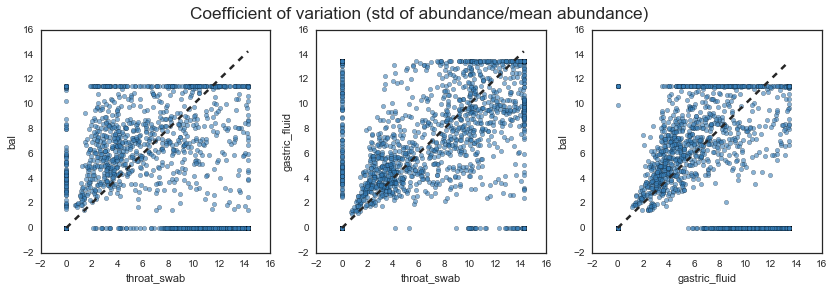

In [82]:
# Plot cv between sites
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('throat_swab', 'bal', cv, ax[0], yx=True)
plotxy('throat_swab', 'gastric_fluid', cv, ax[1], yx=True)
plotxy('gastric_fluid', 'bal', cv, ax[2], yx=True)
plt.suptitle('Coefficient of variation (std of abundance/mean abundance)', fontsize='xx-large')

# Hm, might be better to look at variance of presence/absence of OTUs

The sample estimate of the variance of a binomial is $\frac{(p(1-p))}{n}$. http://www.stat.yale.edu/Courses/1997-98/101/binom.htm

So the estimate of the std is the square root of that.

In [32]:
# Get presence/absence
dflong['present'] = (dflong['abun'] > 0).astype(int)
dflong.head()

,sample,otu,abun,site,subject_id,log_abun,present
0,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.025542,gastric_fluid,01-112-7,-1.592741,1
628,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7,-7.000000,0
1256,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7,-7.000000,0
1884,01-112-7GI,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.000000,gastric_fluid,01-112-7,-7.000000,0
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.000000,gastric_fluid,01-112-7,-7.000000,0


In [33]:
# Get mean number of samples each OTU is in
present = dflong.groupby(['site', 'otu'])['present'].mean().reset_index()
present.columns = ['site', 'otu', 'proportion']

In [34]:
# Need to add number of samples for each site for the std formula
sample_N = dflong[['site', 'sample']].drop_duplicates().groupby('site').size()
sample_N

site
bal              131
gastric_fluid    181
throat_swab      203
dtype: int64

In [35]:
present['n'] = sample_N.loc[present['site']].values

In [36]:
present['std'] = np.sqrt(present['proportion']*(1 - present['proportion']) / present['n'])
present.head()

,site,otu,proportion,n,std
0,bal,k__;p__;c__;o__;f__;g__;s__;d__denovo120,0.030534,131,0.015032
1,bal,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0.000000,131,0.000000
2,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,0.038168,131,0.016740
3,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,0.053435,131,0.019650
4,bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,0.000000,131,0.000000


In [37]:
## Pivot tidy data to long-form for easy plotting

# std
pres_std = present.pivot(index='otu', columns='site', values='std')
pres_std.columns = [c + '-std' for c in pres_std.columns]

# mean proportion
pres_mean = present.pivot(index='otu', columns='site', values='proportion')
pres_mean.columns = [c + '-prop' for c in pres_mean.columns]

# Merge dataframes on OTU
pres_stats = pd.merge(pres_mean, pres_std, left_index=True, right_index=True)

pres_stats.head()

,bal-prop,gastric_fluid-prop,throat_swab-prop,bal-std,gastric_fluid-std,throat_swab-std
otu,,,,,,
k__;p__;c__;o__;f__;g__;s__;d__denovo120,0.030534,0.038674,0.034483,0.015032,0.014332,0.012807
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__;d__denovo285,0.000000,0.005525,0.004926,0.000000,0.005510,0.004914
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,0.038168,0.044199,0.009852,0.016740,0.015277,0.006932
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,0.053435,0.099448,0.059113,0.019650,0.022244,0.016552
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,0.000000,0.000000,0.004926,0.000000,0.000000,0.004914


[(-0.001, 0.045), (-0.001, 0.045), (-0.001, 0.045)]

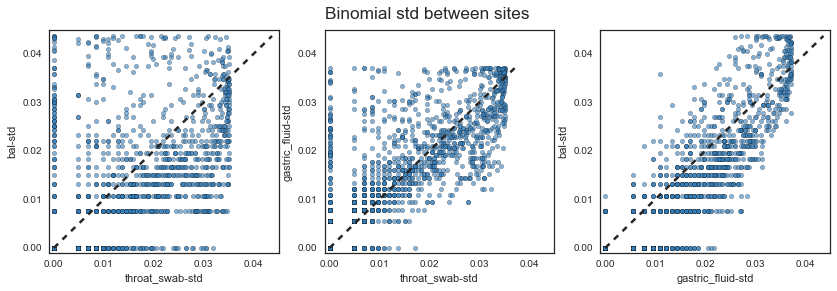

In [38]:
# Plot presence/absence std between sites
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('throat_swab-std', 'bal-std', pres_std, ax[0], yx=True)
plotxy('throat_swab-std', 'gastric_fluid-std', pres_std, ax[1], yx=True)
plotxy('gastric_fluid-std', 'bal-std', pres_std, ax[2], yx=True)
plt.suptitle('Binomial std between sites', fontsize='xx-large')

[ax[i].set_xlim([-0.001, 0.045]) for i in [0, 1, 2]]
[ax[i].set_ylim([-0.001, 0.045]) for i in [0, 1, 2]]

Why are they these weird box shapes that aren't squares...?

Plot mean vs. std in each site

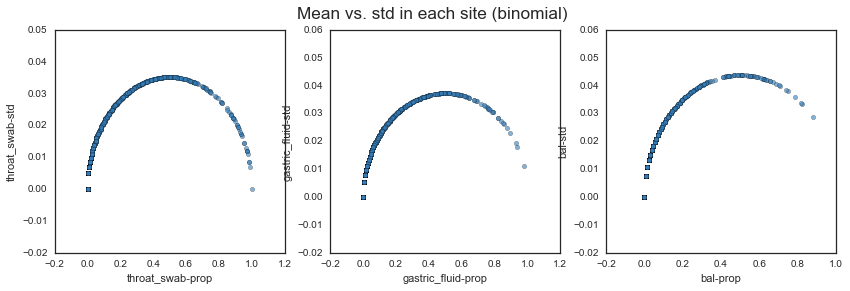

In [39]:
# Plot presence/absence std between sites
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('throat_swab-prop', 'throat_swab-std', pres_stats, ax[0])
plotxy('gastric_fluid-prop', 'gastric_fluid-std', pres_stats, ax[1])
plotxy('bal-prop', 'bal-std', pres_stats, ax[2])
plt.suptitle('Mean vs. std in each site (binomial)', fontsize='xx-large')


## How about std of log(raw counts)?

If this doesn't work, Rafa says I can use another variance stabilizing transformation, which have lots of R packages available

In [13]:
# Use groupby's describe function to get OTU-wise stats
otustats = rawlong.groupby(['site', 'otu']).describe().reset_index()
otustats.head()

site                                                otu   abun            \
                                                           count      mean   
0  bal           k__;p__;c__;o__;f__;g__;s__;d__denovo120  131.0  0.072031   
1  bal  k__Archaea;p__Euryarchaeota;c__Methanobacteria...  131.0  0.000000   
2  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053  131.0  0.040609   
3  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182  131.0  0.034995   
4  bal  k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187  131.0  0.000000   

                                           
        std  min  25%  50%  75%       max  
0  0.485820  0.0  0.0  0.0  0.0  4.368975  
1  0.000000  0.0  0.0  0.0  0.0  0.000000  
2  0.239118  0.0  0.0  0.0  0.0  2.053078  
3  0.172170  0.0  0.0  0.0  0.0  1.505150  
4  0.000000  0.0  0.0  0.0  0.0  0.000000

In [14]:
# I really need to learn how to use Multi-Indices...
cols = ['site', 'otu', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
otustats.columns = cols

In [15]:
# Get dataframe with the standard devs
sitestd = otustats.pivot(index='otu', columns='site', values='std')
sitestd.columns = [c + '-std' for c in sitestd.columns]

# Get another dataframe with the mean abundance
sitemean = otustats.pivot(index='otu', columns='site', values='mean')
sitemean.columns = [c + '-mean' for c in sitemean.columns]

# Merge dataframes on OTU
sitestats = pd.merge(sitestd, sitemean, left_index=True, right_index=True)
sitestats.head()

,bal-std,gastric_fluid-std,throat_swab-std,bal-mean,gastric_fluid-mean,throat_swab-mean
otu,,,,,,
k__;p__;c__;o__;f__;g__;s__;d__denovo120,0.485820,0.241331,0.122940,0.072031,0.035717,0.016789
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__;d__denovo285,0.000000,0.022375,0.021128,0.000000,0.001663,0.001483
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,0.239118,0.105001,0.029806,0.040609,0.021311,0.002966
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,0.172170,0.249739,0.129897,0.034995,0.072525,0.027778
k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,0.000000,0.000000,0.049058,0.000000,0.000000,0.003443


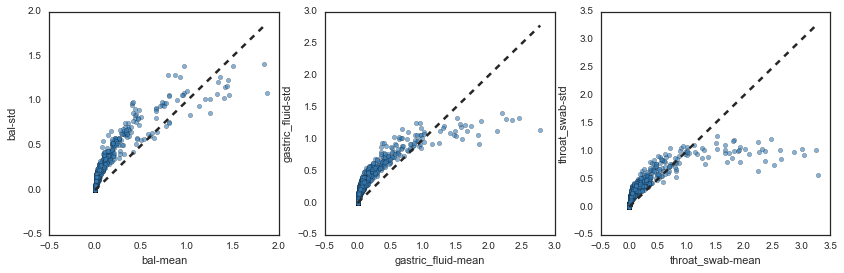

In [18]:
# Plot mean vs. std in each site
sns.set_style('white')
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

plotxy('bal-mean', 'bal-std', sitestats, ax[0], yx=True)
plotxy('gastric_fluid-mean', 'gastric_fluid-std', sitestats, ax[1], yx=True)
plotxy('throat_swab-mean', 'throat_swab-std', sitestats, ax[2], yx=True)

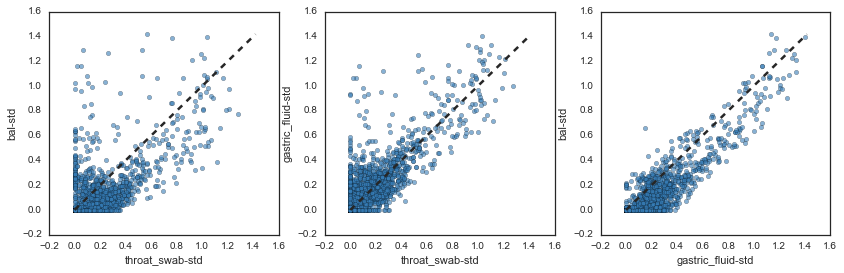

In [19]:
# Plot std across sites
sns.set_style('white')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    
plotxy('throat_swab-std', 'bal-std', sitestats, ax[0], yx=True)
plotxy('throat_swab-std', 'gastric_fluid-std', sitestats, ax[1], yx=True)
plotxy('gastric_fluid-std', 'bal-std', sitestats, ax[2], yx=True)

How many OTUs are above and below the y=x line for each of these plots?

In [25]:
print(sum(sitestats['bal-std'] > sitestats['throat_swab-std']) / float(sitestats.shape[0]))

print(sum(sitestats['gastric_fluid-std'] > sitestats['throat_swab-std']) / float(sitestats.shape[0]))

print(sum(sitestats['bal-std'] > sitestats['gastric_fluid-std']) / float(sitestats.shape[0]))


0.192648922687
0.551330798479
0.119138149556


# Let's cut to the chase

What I really want to answer is: are throat OTUs less variable than lung OTUs, which are similarly variable to gastric OTUs?

Let's just make boxplots of the std, calculated in various different ways...

/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


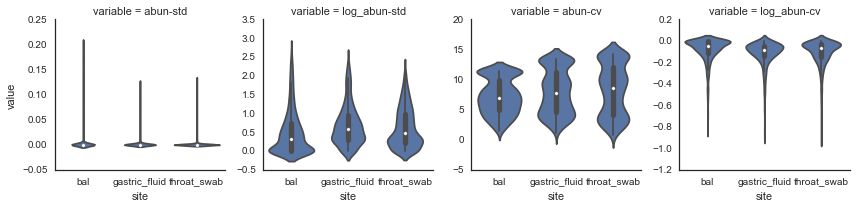

In [40]:
tmp = otustats[['site', 'otu', 'abun-std', 'log_abun-std', 'abun-cv', 'log_abun-cv']]\
    .melt(id_vars=['site', 'otu'])

g = sns.FacetGrid(col='variable', data=tmp, sharey=False)
g.map(sns.violinplot, 'site', 'value')

Wait no, these should be paired plots! That's why they're not telling me anything right now.

In [39]:
## Plot bal - throat, gastric - throat, bal - gastric
sitestats.head()

s1 = 'bal'
s2 = 'throat_swab'
sitestats['{}-minus-{}'.format(s1, s2)] = sitestats['{}-std'.format(s1)] - sitestats['{}-std'.format(s2)]
s1 = 'gastric_fluid'
sitestats['{}-minus-{}'.format(s1, s2)] = sitestats['{}-std'.format(s1)] - sitestats['{}-std'.format(s2)]
s1 = 'bal'
s2 = 'gastric_fluid'
sitestats['{}-minus-{}'.format(s1, s2)] = sitestats['{}-std'.format(s1)] - sitestats['{}-std'.format(s2)]

In [44]:
# Plot std across sites
cols = ['bal-minus-throat_swab', 'gastric_fluid-minus-throat_swab', 'bal-minus-gastric_fluid']
diffs = pd.melt(sitestats[cols].reset_index(), id_vars='otu')
diffs.head()

,otu,variable,value
0,k__;p__;c__;o__;f__;g__;s__;d__denovo120,bal-minus-throat_swab,0.054592
1,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,bal-minus-throat_swab,-0.000003
2,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,bal-minus-throat_swab,0.001506
3,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,bal-minus-throat_swab,0.000021
4,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,bal-minus-throat_swab,-0.000003


/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


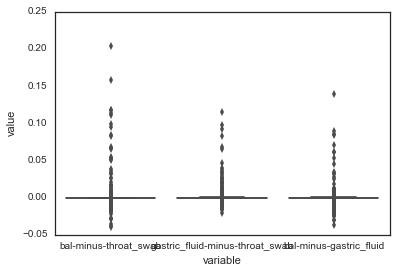

In [45]:
sns.boxplot(data=diffs, x='variable', y='value')

In [50]:
from scipy.stats import wilcoxon

print(wilcoxon(sitestats['bal-std'], sitestats['throat_swab-std']))
print(wilcoxon(sitestats['bal-std'], sitestats['gastric_fluid-std']))
print(wilcoxon(sitestats['gastric_fluid-std'], sitestats['throat_swab-std']))

WilcoxonResult(statistic=336789.0, pvalue=6.5065270887718263e-28)
WilcoxonResult(statistic=277150.0, pvalue=1.0571852237791382e-52)
WilcoxonResult(statistic=465222.0, pvalue=2.2984273073453161e-09)
